In [43]:
''' The aim of this project is to predict Autism Spectrum Disorder (ASD) in toddlers and adults when some behavioural
    features and personal attributes of some individuals are known. The data was obtained from kaggle website. 
    The data was cleaned, then explored and a classification model was built to predict ASD'''

__author__ = 'Sakiru Badmos (PhD)'
__email__ = 'babs4sure86@gmail.com'

# Can Autism Spectrum Disorder (ASD) in toddlers be predicted given some behavioral and individual features?

There are over 100,000 children in the UK who have been diagnosed with Autism Spectrum Disorder (ASD). Children on the ASD spectrum tend to show social interaction difficulties as well as speech and language problem.  Parents of children on ASD spectrum is faced with the challenge of dealing with the behaviour and also providing adequate support for the children to help them improve in the aspect of child development impacted by ASD. 
Children with potential ASD shows some behavioral signs including minimal eye contact, delayed speech, non-flexibility (getting really upset with change of routine), being obsessed with one toy, having trouble understanding other people’s feelings, struggling with jokes or sarcasm, and repetitive behavior. This is not an exhaustive list of the signs of ASD in toddlers.<br /> 
ASD diagnosis commences with parents of the child completing a Modified Checklist for Autism in Toddlers (M-CHAT). It is an early test for children between 16-30 months. However, this is not a proper diagnosis but could points to whether the child could develop ASD or not. Early detection of ASD is crucial as early intervention significantly improves the child’s condition. Children with ASD could get help from developmental pediatrician, occupational therapist, speech therapist and educational psychologist. It should be noted that confirmatory ASD diagnosis is usually delayed till a child is about 4-5 years. However, early prediction of the possibility of a child having ASD will significantly improve the child’s behavior, as appropriate support will be provided early.<br />  
In this project, I explored Autism data obtained from Kaggle website to predict ASD in adults given some behavioural and individual features.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import warnings
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
warnings.filterwarnings('ignore')

In [44]:
#Define helper functions
def load_data(file):
    '''loads csv file into a pandas dataframe'''
    return pd.read_csv(file)

def rename_col(df, rename_dict):
    '''renames the column names of input dataframe'''
    df.rename(rename_dict, axis = 1, inplace= True)
    
def group_col(df):
    '''puts features into groups'''
    global numerical_var, cat_num_var, cat_var
    numerical_var = [col for col in df.columns if df[col].dtype !='O' and 
                 col not in ['Class', 'Case_No'] and df[col].nunique() > 30]
    cat_num_var = [col for col in df.columns if df[col].dtype !='O' and 
                     col not in ['Class', 'Case_No']]
    cat_var = [col for col in df.columns if df[col].dtype =='O' and col not in ['Class', 'Case_No']]
    return numerical_var, cat_var, cat_num_var

def transform_binary(df, col):
    '''label encode categorical variables with yes/no values'''
    df[col] = df[col].str.lower()
    df[col] = df[col].map({'yes': 1, 'no': 0})
    
def plot_cat_feature(df, col):
    '''plots counts of unique values in categorical features'''
    df[col].value_counts().sort_index().plot(kind= 'bar')
    plt.xlabel(col)
    plt.ylabel('Counts')

def plot_outcome(df, col):
    '''plots counts of class labels of the target class'''
    plt.figure(figsize = (14, 6))
    plt.subplot(1,2,1)
    df.loc[df['Class'] == 1, col].value_counts().sort_index().plot(kind= 'bar')
    plt.title('Positive Class')
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(1,2,2)
    df.loc[df['Class'] == 0, col].value_counts().sort_index().plot(kind= 'bar')
    plt.title('Negative Class')
    plt.xlabel(col)
    plt.ylabel('Counts')
    
def plot_outcome_fraction(df, col):
    '''plots fraction of each lable in the target'''
    positive = df.loc[df['Class'] == 1, col].value_counts()
    negative = df.loc[df['Class'] == 0, col].value_counts()
    pos_fraction = positive/(positive+negative)
    neg_fraction = negative/(positive+negative)
    plt.figure(figsize = (14, 6))
    plt.subplot(1,2,1)
    pos_fraction.plot(kind= 'bar')
    plt.title('Positive Class')
    plt.xlabel(col.capitalize())
    plt.ylabel('Fraction of class')
    plt.subplot(1,2,2)
    neg_fraction.plot(kind= 'bar')
    plt.title('Negative Class')
    plt.xlabel(col.capitalize())
    plt.ylabel('Fraction of class')

def check_null(df):
    '''returns the number of null entries in each column in input dataframe'''
    return df.isnull().sum()/len(df)

def check_duplicates(df,subset):
    '''returns the number of duplicated rows'''
    return df.duplicated(subset=subset).sum()
    
def encode_feature(df):
    '''one-hot-encode categorical columns in input dataframe '''
    return pd.get_dummies(df, drop_first=True)

def plot_corr(df):
    '''plot correlation between features and target'''
    plt.figure(figsize= (15,10))
    sns.heatmap(df.corr('spearman'), annot= True, linewidths= 0.15)
    plt.savefig('corrplot_toddler.png')
    plt.show()

def get_target(df, target):
    '''separates target from input dataframe'''
    return df[target]

def model_trainer(model, X_train, y_train):
    '''trains the model'''
    model.fit(X_train, y_train)
    
def print_test_score(model, X_test, y_test, test_acc):
    acc = model.score(X_test, y_test)
    test_acc[model] = acc
    print('\nModel:\n', model)
    print('Test Accuracy:\n', acc)


def print_train_summary(model, train_acc):
    print('\nModel:\n', model)
    print('Training Accuracy:\n', train_acc[model])
    
def print_gs_summary(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)
    
def get_model_score(X_test, y_test, model= None):
    '''calculates accuracy and f1 scores of the model during model evaluation'''
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)*100
    precision = precision_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    
    print('Accuracy is : {:.2g}'.format(accuracy))
    print('Precision is : {:.2g}'.format(precision))
    print('Recall is : {:.2g}'.format(recall))
    f1 = 2*precision*recall/(precision+recall)
    f1_weighted = f1_score(y_test, y_pred, average = 'weighted')*100
    
    print('f1 score (weighted) is : {:.2g}'.format(f1_weighted))
    print('f1 score (calculated) is : {:.2g}'.format(f1))
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
def get_cross_val_score_(X_train, y_train, model = None, model_name= None, option=None):
    '''calculates mean accuracy and f1 scores from cross validation'''
    avg_accuracy= np.mean(cross_val_score(model, X_train, y_train, scoring= 'accuracy', cv=cv)) *100
    print("The mean accuracy for cross validation on {} set is {:2g}".format(option,avg_accuracy))
    
    avg_precision= np.mean(cross_val_score(model, X_train, y_train, scoring= 'precision', cv=cv)) *100
    print("The mean precision for cross validation on {} set is {:2g}".format(option,avg_precision))
    
    avg_recall= np.mean(cross_val_score(model, X_train, y_train, scoring= 'recall', cv=cv)) *100
    print("The mean recall for cross validation on {} set is {:2g}".format(option,avg_recall))
    
    avg_f1_weighted= np.mean(cross_val_score(model, X_train, y_train, scoring= 'f1_weighted', cv=cv))*100
    print("The mean F1-score (weighted) for cross validation on {} set is {:2g}".format(option, avg_f1_weighted))
    
    avg_f1_micro= np.mean(cross_val_score(model, X_train, y_train, scoring= 'f1_micro', cv=cv))*100
    print("The mean F1-score (micro) for cross validation on {} set is {:2g}".format(option, avg_f1_micro))
    
    avg_f1_macro= np.mean(cross_val_score(model, X_train, y_train, scoring= 'f1_macro', cv=cv))*100
    print("The mean F1-score (macro) for cross validation on {} set is {:2g}".format(option, avg_f1_macro))
    
    avg_f1= (2 * avg_precision * avg_recall)/(avg_precision + avg_recall)
    print("The mean F1-score (calculated) for cross validation on {} set is {:2g}".format(option,avg_f1))
    
def plot_feature_importance(model):
    fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, figsize=(10,8))
    model_1_FI = pd.Series(model[0].best_estimator_.feature_importances_, index=X_train.columns).head(15).sort_values()
    model_2_FI = pd.Series(model[1].best_estimator_.feature_importances_, index=X_train.columns).head(15).sort_values()
    model_3_FI = pd.Series(model[2].best_estimator_.feature_importances_, index=X_train.columns).head(15).sort_values()
    model_4_FI = pd.Series(model[3].best_estimator_.feature_importances_, index=X_train.columns).head(15).sort_values()
    ax1.barh(model_1_FI.index, model_1_FI.values, color='red')
    ax2.barh(model_2_FI.index, model_2_FI.values, color='blue')
    ax3.barh(model_3_FI.index, model_3_FI.values, color='green')
    ax4.barh(model_4_FI.index, model_4_FI.values, color='purple')
    #print(dt_feature_importances)
    ax1.set_title(' Decision Tree Feature Importances')
    ax1.set_xlabel('Importances')
    ax1.set_ylabel('Features')
    ax2.set_title('Random Forest Feature Importances')
    ax2.set_xlabel('Importances')
    ax2.set_ylabel('Features')
    ax3.set_title('Gradient Boosting Feature Importances')
    ax3.set_xlabel('Importances')
    ax3.set_ylabel('Features')
    ax4.set_title('Adaboost Feature Importances')
    ax4.set_xlabel('Importances')
    ax4.set_ylabel('Features')
    plt.tight_layout()
    plt.savefig('DT_toddler.png')
    
def print_predict_summary(model, test_features, test_target, test_acc):
    global y_pred
    y_pred= model.predict(test_features)
    class_r= classification_report(test_target, y_pred, target_names= ['Positive', 'Negative'])
    accuracy= accuracy_score(test_target, y_pred)*100
    test_acc[model] = accuracy
    print('\nClass report:\n', class_r)
    print('Test Accuracy:\n', test_acc[model])

def print_confusion_matrix(y_test, y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    class_names=[0,1] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
def plot_roc(model, X_test, y_test):
    '''Takes model, and testing data as arguments and plots the ROC curve '''
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

**Load data**

In [3]:
# load data from csv
autism_data = load_data('Toddler_Autism.csv')

In [4]:
autism_data.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


In [5]:
#Rename columns
rename_dict = {'Family_mem_with_ASD': 'ASD_History', 
                   'Who completed the test':'Test_taker_rel',
                 'Class/ASD Traits ':'Class', 'Age_Mons':'Age' }
rename_col(autism_data, rename_dict)
autism_data.columns

Index(['Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'Age', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice', 'ASD_History',
       'Test_taker_rel', 'Class'],
      dtype='object')

In [6]:
autism_data.columns

Index(['Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'Age', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice', 'ASD_History',
       'Test_taker_rel', 'Class'],
      dtype='object')

In [7]:
# convert Test_taker_rel values to all lower case
autism_data['Test_taker_rel'] = autism_data['Test_taker_rel'].str.lower()

In [8]:
#Group columns into numerical, categorical and categorical numerical features
group_col(autism_data)

([],
 ['Sex', 'Ethnicity', 'Jaundice', 'ASD_History', 'Test_taker_rel'],
 ['A1',
  'A2',
  'A3',
  'A4',
  'A5',
  'A6',
  'A7',
  'A8',
  'A9',
  'A10',
  'Age',
  'Qchat-10-Score'])

## Exploratory Data Analysis

**Examine the data**

In [9]:
#Examine the number of records and columns 
autism_data.shape

(1054, 19)

In [10]:
autism_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 19 columns):
Case_No           1054 non-null int64
A1                1054 non-null int64
A2                1054 non-null int64
A3                1054 non-null int64
A4                1054 non-null int64
A5                1054 non-null int64
A6                1054 non-null int64
A7                1054 non-null int64
A8                1054 non-null int64
A9                1054 non-null int64
A10               1054 non-null int64
Age               1054 non-null int64
Qchat-10-Score    1054 non-null int64
Sex               1054 non-null object
Ethnicity         1054 non-null object
Jaundice          1054 non-null object
ASD_History       1054 non-null object
Test_taker_rel    1054 non-null object
Class             1054 non-null object
dtypes: int64(13), object(6)
memory usage: 156.5+ KB


Looks like the data has no missing values

In [11]:
# Check for duplicates
check_duplicates(autism_data, 'Case_No')

0

No duplicate found

In [12]:
# Check for missing values
check_null(autism_data)

Case_No           0.0
A1                0.0
A2                0.0
A3                0.0
A4                0.0
A5                0.0
A6                0.0
A7                0.0
A8                0.0
A9                0.0
A10               0.0
Age               0.0
Qchat-10-Score    0.0
Sex               0.0
Ethnicity         0.0
Jaundice          0.0
ASD_History       0.0
Test_taker_rel    0.0
Class             0.0
dtype: float64

The data contains no missing value

**Data Cleaning**

In [13]:
# Transform all columns with yes/no values to 1/0
column_to_transform = ['Jaundice', 'ASD_History', 'Class']
for col in column_to_transform:
    transform_binary(autism_data, col)

In [14]:
autism_data.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age,Qchat-10-Score,Sex,Ethnicity,Jaundice,ASD_History,Test_taker_rel,Class
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,1,0,family member,0
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,1,0,family member,1
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,1,0,family member,1
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,0,0,family member,1
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,0,1,family member,1


**Visualize features**

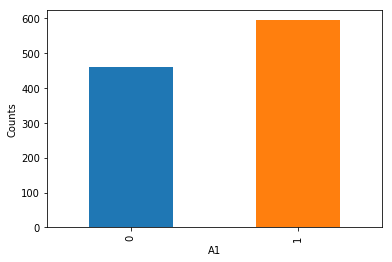

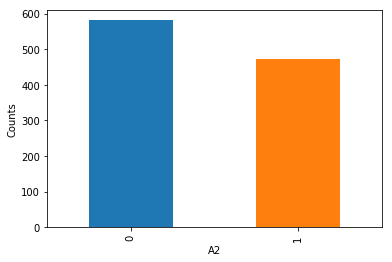

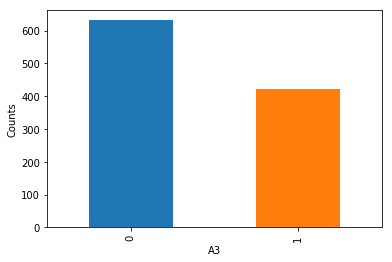

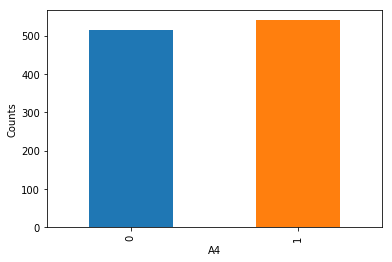

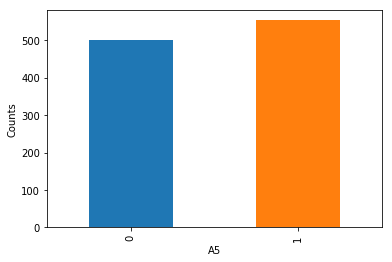

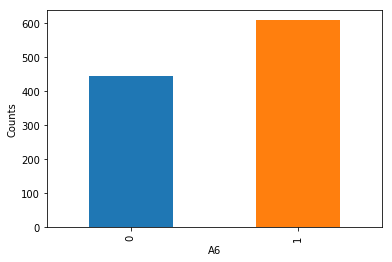

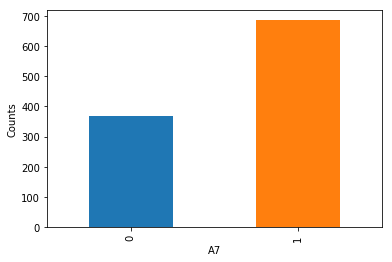

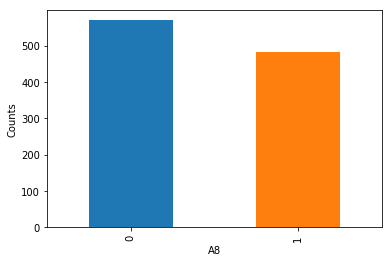

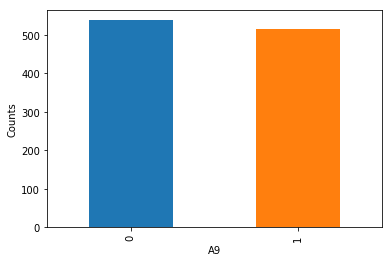

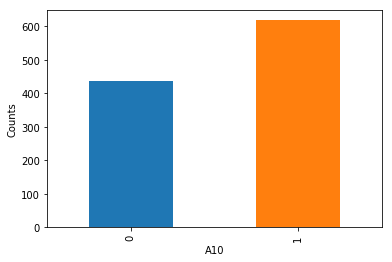

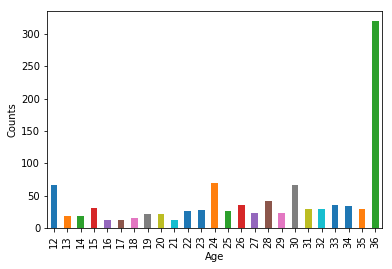

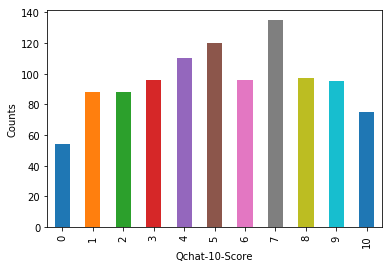

In [15]:
for col in cat_num_var:
    plot_cat_feature(autism_data, col)
    plt.show()

The A1-A10 columns have reasonable distributions of the labels. It looks like toddlers of 36 months participated the most.

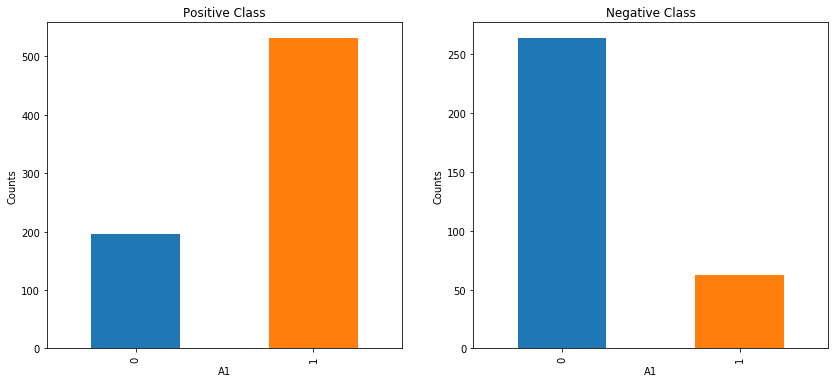

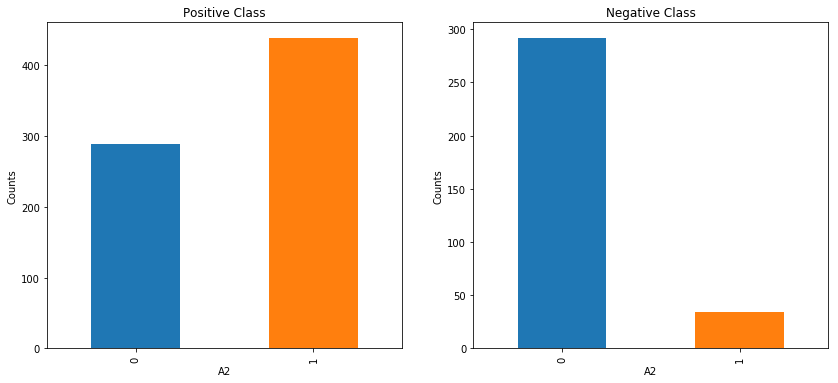

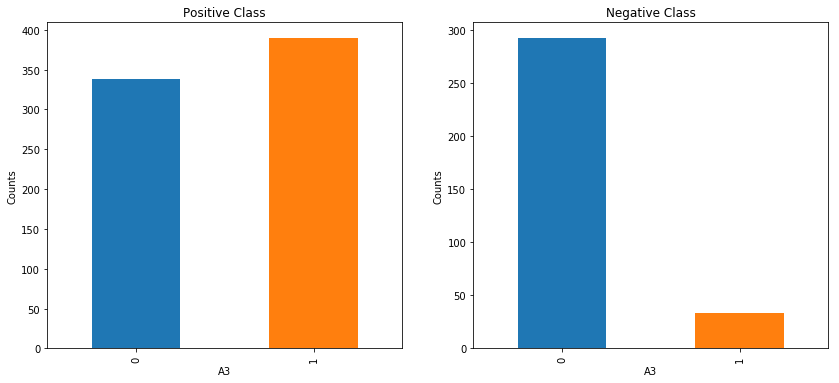

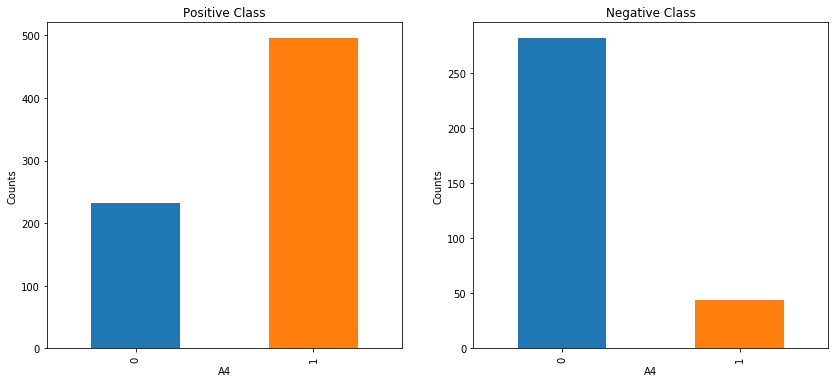

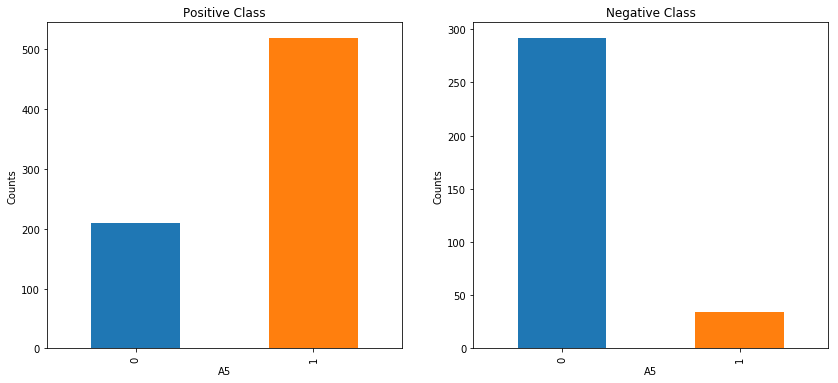

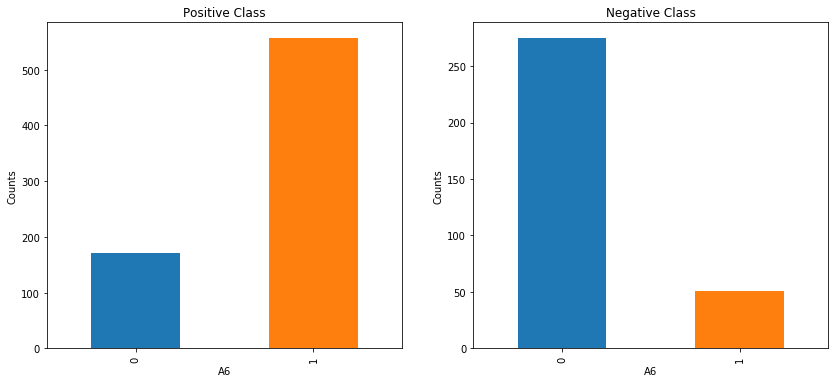

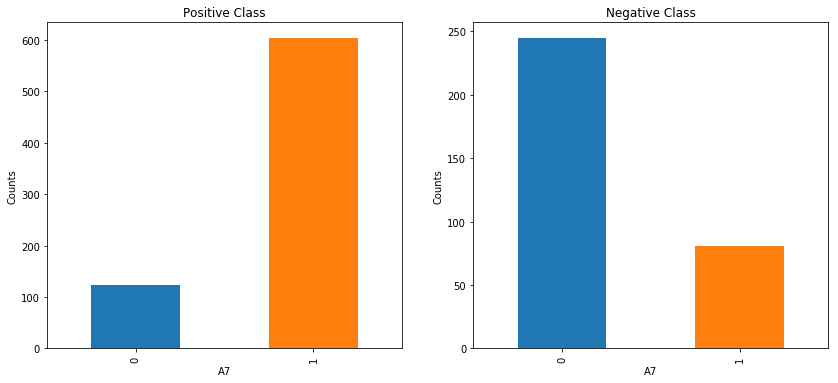

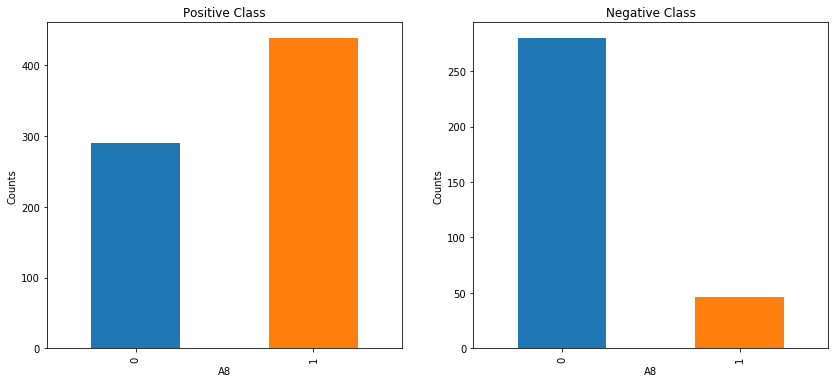

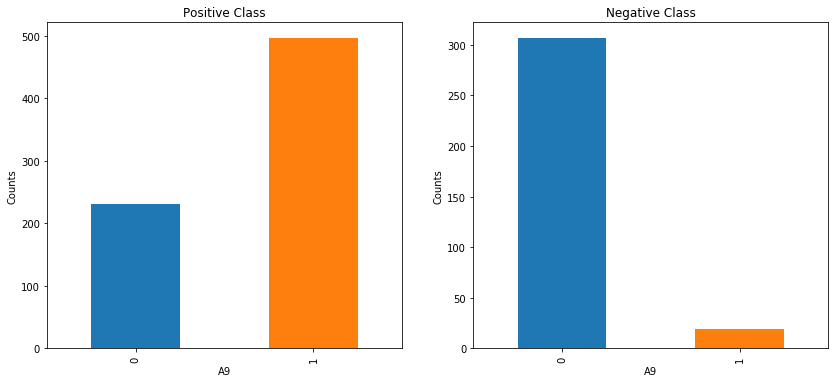

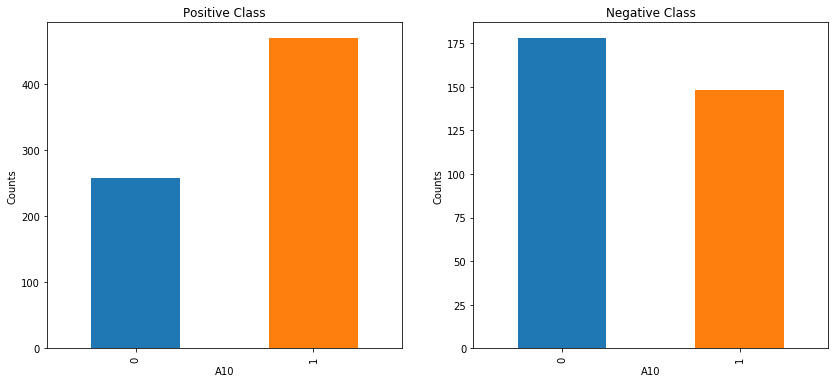

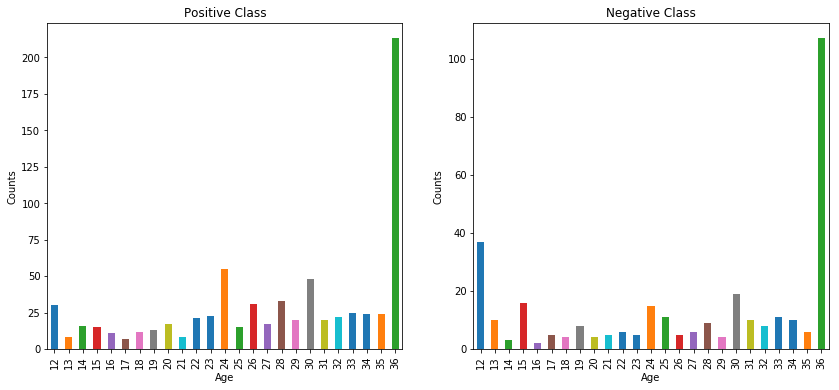

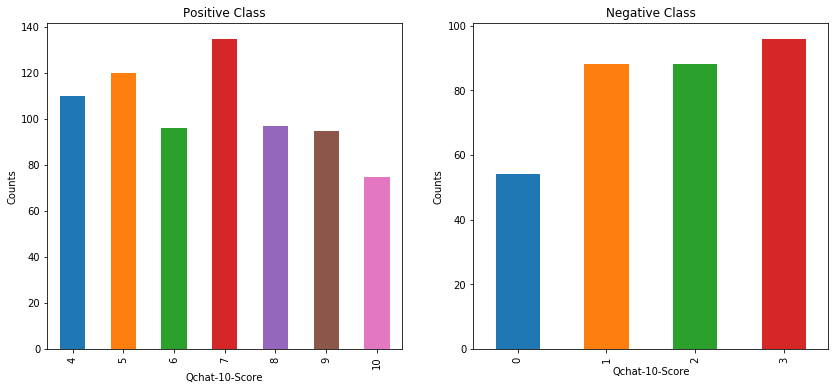

In [16]:
# The plot_outcome function plots the distribution of the feature at each target label. 
# For example, how many people who had autism answered 'Yes' for A1_Score and how many people answered 'No' 
for col in cat_num_var:
    plot_outcome(autism_data, col)
    plt.show()

Based on the distribution of the class labels, people that had autism in general answered yes for A1-A10 scores and people that answered no did not have autism. This shows that there is an association between the responses to these questions and being autistic.

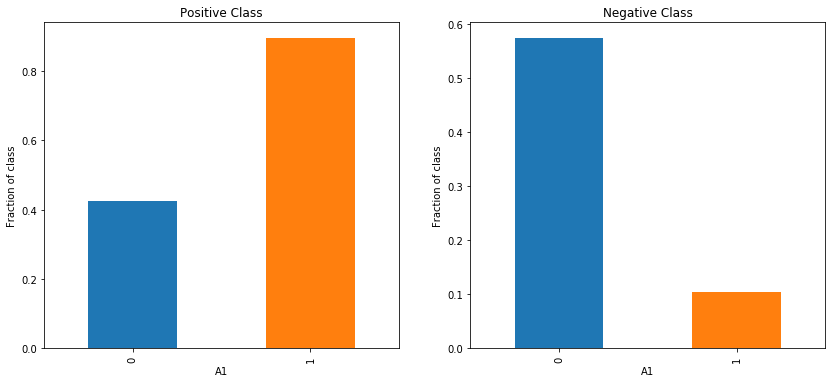

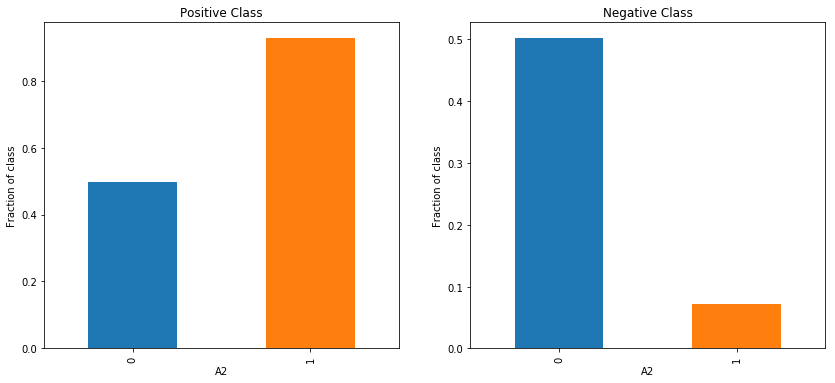

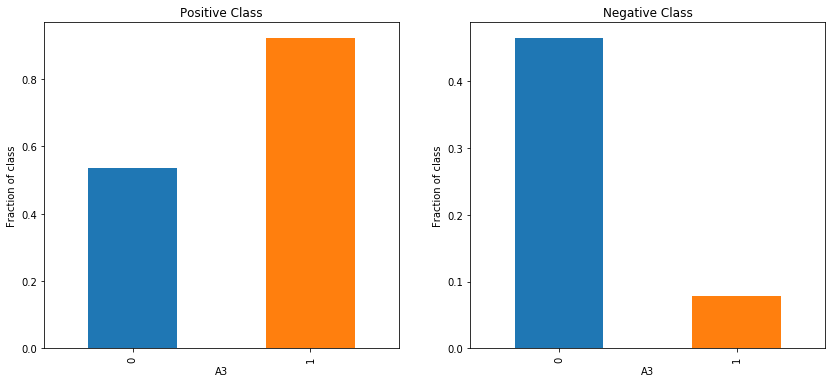

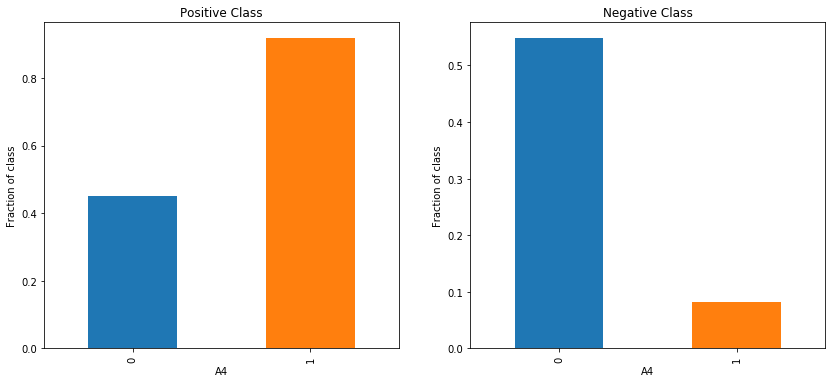

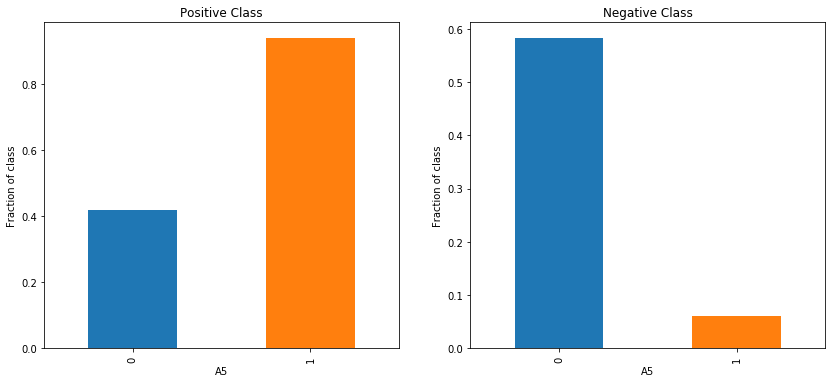

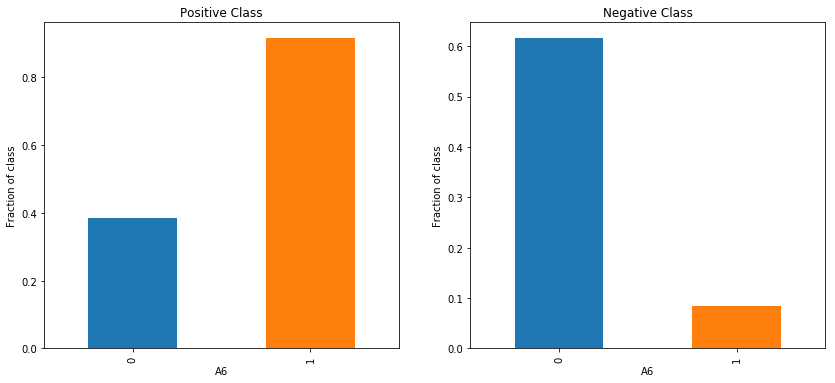

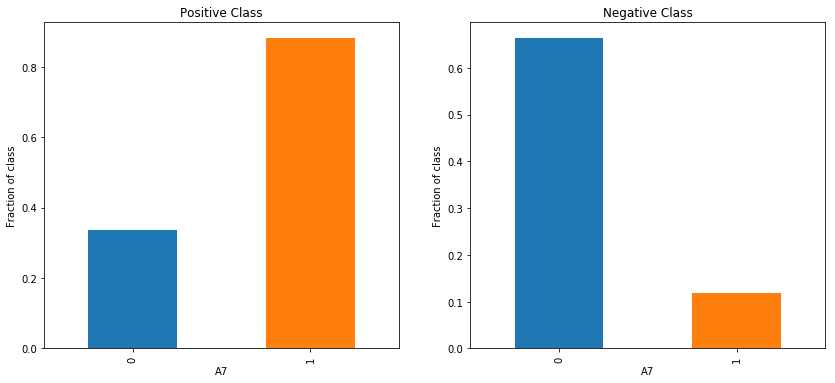

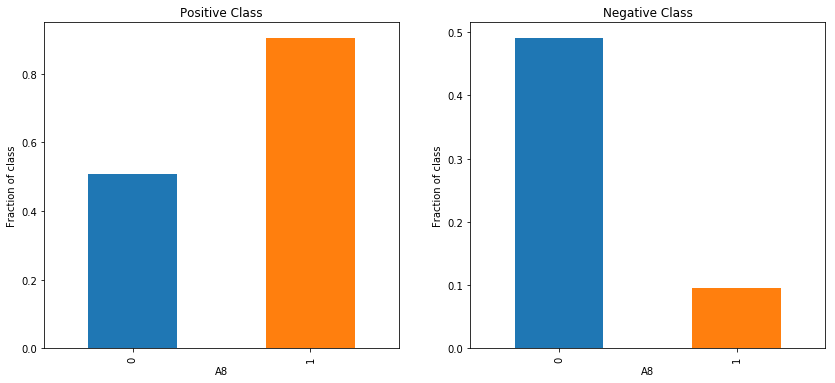

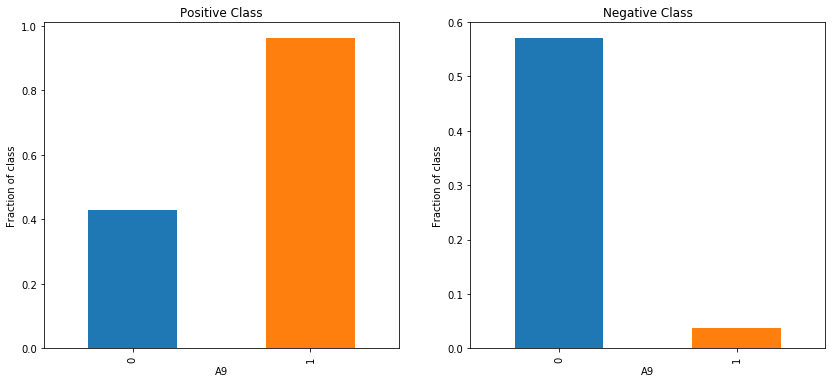

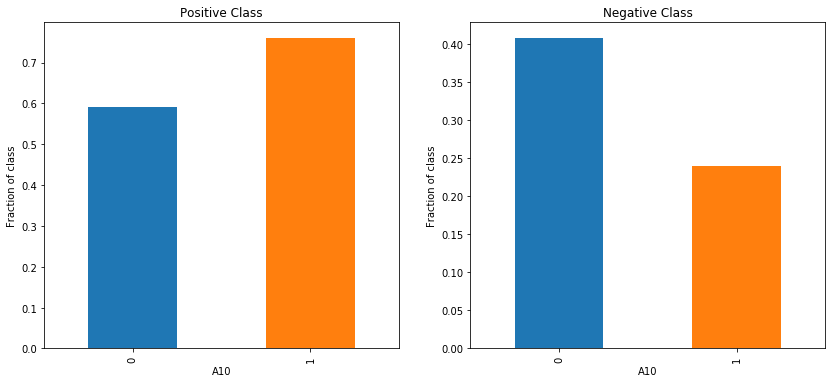

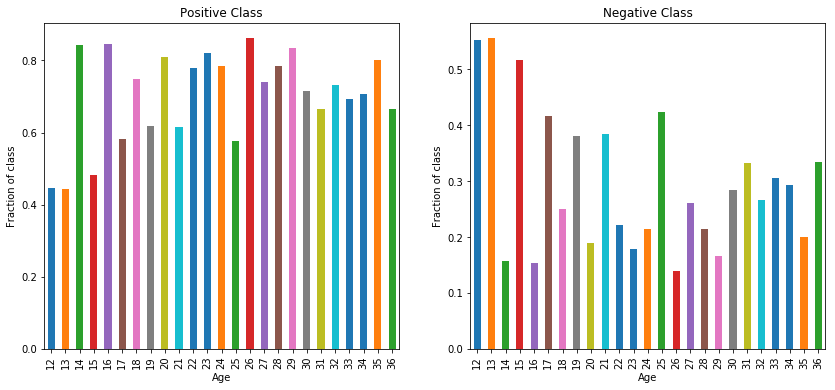

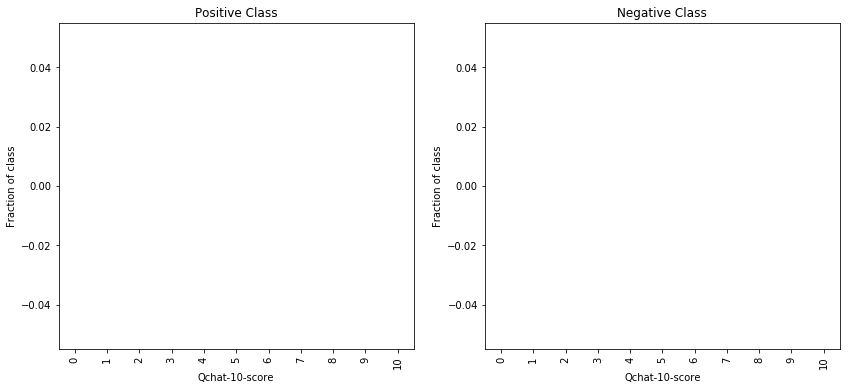

In [17]:
for col in cat_num_var:
    plot_outcome_fraction(autism_data, col)
    plt.show()

There is random distribution of the postive and negative class for different ages. This suggests that the age at which the test is taken does not have strong correlation with autism

In [18]:
autism_data.loc[autism_data['Class'] == 1, 'Ethnicity'].value_counts()

White European    250
asian             212
middle eastern     96
black              39
south asian        37
Hispanic           30
Others             29
Latino             20
Pacifica            7
mixed               5
Native Indian       3
Name: Ethnicity, dtype: int64

**Plot categorical features**

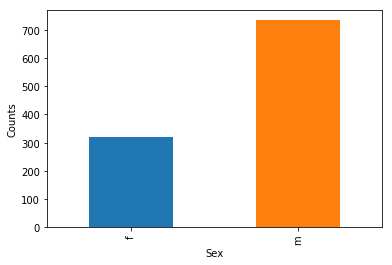

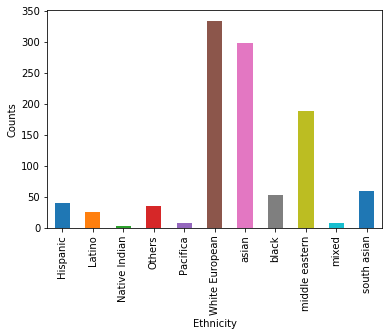

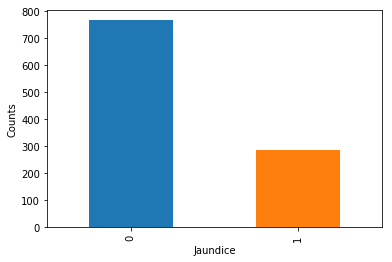

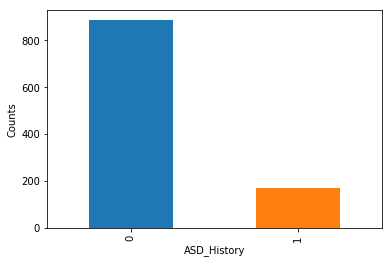

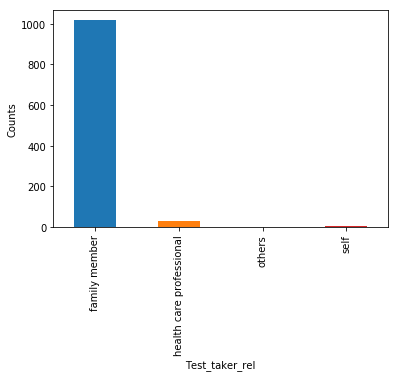

In [19]:
for col in cat_var:
    plot_cat_feature(autism_data, col)
    plt.show()

From the plot of categorical features:
- There are more male participants than females
- There are more white europeans and Asians
- Most of the children did not have jaundice at birth
- Most of them do not have family history of autism
- The questionnaires were mostly answered by a family member

Irrelevant columns should be dropped. The 'Qchat-10-Score' column needs to be dropped as it was used to determine the class. This is necessary to prevent overfitting and target leakage. The Case_No column is also not relevant for prediction

In [20]:
# save a copy of te data
autism_data_copy = autism_data.copy()

In [21]:
autism_data.drop(['Case_No', 'Qchat-10-Score'], axis= 'columns', inplace= True)

In [22]:
autism_data.columns

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'Age',
       'Sex', 'Ethnicity', 'Jaundice', 'ASD_History', 'Test_taker_rel',
       'Class'],
      dtype='object')

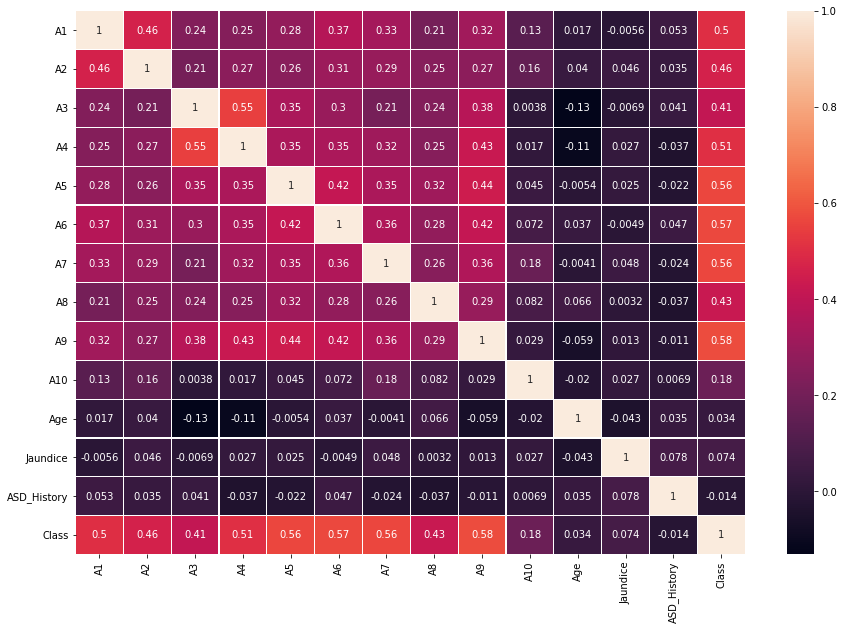

In [23]:
plot_corr(autism_data)

The correlation plot shows that A1 - A10 are strongly correlated with the target. The age of the child, whether the child developed jaundice and family history of autism are weakly correlated with the target. They might not be good predictors.

**Convert categorical features to numerical by one-hot-encoding**

In [24]:
autism_data = encode_feature(autism_data)

In [25]:
autism_data.shape

(1054, 28)

In [26]:
autism_data.iloc[:,10:].head(5)

,Age,Jaundice,ASD_History,Class,Sex_m,Ethnicity_Latino,Ethnicity_Native Indian,Ethnicity_Others,Ethnicity_Pacifica,Ethnicity_White European,Ethnicity_asian,Ethnicity_black,Ethnicity_middle eastern,Ethnicity_mixed,Ethnicity_south asian,Test_taker_rel_health care professional,Test_taker_rel_others,Test_taker_rel_self
0,28,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,36,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,36,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,24,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [27]:
autism_data.columns

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'Age',
       'Jaundice', 'ASD_History', 'Class', 'Sex_m', 'Ethnicity_Latino',
       'Ethnicity_Native Indian', 'Ethnicity_Others', 'Ethnicity_Pacifica',
       'Ethnicity_White European', 'Ethnicity_asian', 'Ethnicity_black',
       'Ethnicity_middle eastern', 'Ethnicity_mixed', 'Ethnicity_south asian',
       'Test_taker_rel_health care professional', 'Test_taker_rel_others',
       'Test_taker_rel_self'],
      dtype='object')

## Build the Model

When building machine learning (ML) models, It is important to have a reference baseline model. Logistic regression is a common baseline model used in ML space. However, because the dataset comprises of mostly categorical features, a linear model might not be a good baseline. As a result, a model that predicts the majority class is chosen. This model will have an accuracy that is equal to the fraction of the majority class in the target.

In [28]:
# Obtain fraction of the majority class to be used as the baseline accuracy
autism_data_copy['Class'].value_counts(normalize=True)

1    0.690702
0    0.309298
Name: Class, dtype: float64

In [29]:
baseline_accuracy = (autism_data_copy['Class'].value_counts(normalize=True).loc[1])*100

In [30]:
baseline_accuracy

69.07020872865274

The baseline accuracy is 69%

In [31]:
autism_data_copy['Class'].value_counts(normalize=True)

1    0.690702
0    0.309298
Name: Class, dtype: float64

In [32]:
features = autism_data.drop('Class', axis = 'columns')
target = autism_data['Class']

In [33]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape

((843, 27), (211, 27))

In [34]:
#initialize models list to store the models to run
models = []

In [35]:
cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)
DT_model = DecisionTreeClassifier(random_state=42)
gnb_model = GaussianNB()
svc= SVC(class_weight= 'balanced', probability= True, random_state= 42)
pipeline_svcb = Pipeline([('scaler', StandardScaler()),('svc', svc)])
rf_model = RandomForestClassifier(n_estimators= 10, max_depth=5, class_weight= 'balanced', random_state = 42)
gb_model= GradientBoostingClassifier(n_estimators= 10, max_depth= 5, random_state= 42)
adb = AdaBoostClassifier(n_estimators= 10, random_state= 42)

models.extend([gnb_model, DT_model, rf_model, gb_model, adb, pipeline_svcb]) #, rf_model, pipeline_svcb, gb_model, gnb_model, adb])
for model in models:
    print(model)
    print('*'*70)
    model_trainer(model, X_train, y_train)
    get_model_score(X_test, y_test, model= model)
    print('*'*70)
    get_cross_val_score_(X_train, y_train, model=model, option='Training')
    print('*'*70)
    get_cross_val_score_(X_test, y_test, model=model, option = 'Test')
    print('*'*70)
    
models = []    

GaussianNB(priors=None, var_smoothing=1e-09)
**********************************************************************
Accuracy is : 62
Precision is : 98
Recall is : 44
f1 score (weighted) is : 61
f1 score (calculated) is : 60
[[68  1]
 [80 62]]
**********************************************************************
The mean accuracy for cross validation on Training set is 62.1816
The mean precision for cross validation on Training set is 98.8143
The mean recall for cross validation on Training set is 46.1017
The mean F1-score (weighted) for cross validation on Training set is 62.085
The mean F1-score (micro) for cross validation on Training set is 62.1816
The mean F1-score (macro) for cross validation on Training set is 61.9954
The mean F1-score (calculated) for cross validation on Training set is 62.871
**********************************************************************
The mean accuracy for cross validation on Test set is 66.4198
The mean precision for cross validation on Test set is

Accuracy is : 96
Precision is : 99
Recall is : 94
f1 score (weighted) is : 96
f1 score (calculated) is : 97
[[ 68   1]
 [  8 134]]
**********************************************************************
The mean accuracy for cross validation on Training set is 96.9153
The mean precision for cross validation on Training set is 98.7855
The mean recall for cross validation on Training set is 96.7565
The mean F1-score (weighted) for cross validation on Training set is 96.9338
The mean F1-score (micro) for cross validation on Training set is 96.9153
The mean F1-score (macro) for cross validation on Training set is 96.405
The mean F1-score (calculated) for cross validation on Training set is 97.7605
**********************************************************************
The mean accuracy for cross validation on Test set is 95.7243
The mean precision for cross validation on Test set is 95.9048
The mean recall for cross validation on Test set is 97.9064
The mean F1-score (weighted) for cross val

## Hyperparameter tuning

In [36]:

cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)
gnb = GaussianNB()

param_gnb= {'var_smoothing': np.logspace(-10,10,21)}

gs_gnb = GridSearchCV(gnb, param_grid= param_gnb, cv=cv)
#--------------------------------------------------------------------------------

dt_classifier = DecisionTreeClassifier(max_depth= 15, class_weight= 'balanced', random_state = 42)
dt_max_depths = np.linspace(1, 32, 32, endpoint=True)
dt_min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
dt_min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
dt_max_features = list(range(1,X_train.shape[1]))
dt_param_grid = {'max_depth': range(2,15),
             'max_leaf_nodes': [None, 5, 10, 20, 40, 60, 80, 100]}
dt_grid_params = {'max_depth': dt_max_depths, 'min_sample_splits':dt_min_samples_splits}
gs_dt = GridSearchCV(dt_classifier, param_grid= dt_param_grid, scoring= 'f1_macro', cv= cv)
#--------------------------------------------------------------------------------


svc= SVC(class_weight= 'balanced', probability= True, random_state= 42)
pipeline_svc = Pipeline([('scaler', StandardScaler()),('svc', svc)])
#--------------------------------------------------------------------------------
rf_param_grid = {'max_depth': range(2,15),
             'n_estimators': [10,20,50, 100,200]}

rf_classifier= RandomForestClassifier(n_estimators= 10, class_weight= 'balanced', random_state = 42)
gs_rf_classifier = GridSearchCV(rf_classifier, param_grid=rf_param_grid, scoring= 'f1_macro', cv= cv)
#--------------------------------------------------------------------------------
gb1= GradientBoostingClassifier(random_state= 42)
param_grid_gbl = {'max_depth': range(2,6),
             'n_estimators': [10,20,50, 100,200]}

gs_gb = GridSearchCV(gb1, param_grid= param_grid_gbl, scoring= 'f1_macro', cv= cv)
#--------------------------------------------------------------------------------
adb = AdaBoostClassifier(random_state= 42)
param_grid_adb = {'learning_rate': [0.01, 0.1, 1],
             'n_estimators': [10,20,50, 100,200]}

gs_adb= GridSearchCV(adb, param_grid= param_grid_adb,scoring= 'f1_macro', cv=cv)

In [37]:
#initialize gs_model list to store the models to run
gs_models = []

In [38]:
#gs_models.extend([gs_pipeline_lr, gs_gnb, gs_dt, gs_rf_classifier, gs_adb, gs_gb])
gs_models.extend([gs_gnb, gs_dt, gs_rf_classifier, gs_gb, gs_adb])#, gs_rf_classifier, gs_adb, gs_gb])
for model in gs_models:
    model_trainer(model, X_train, y_train)
    print(model.best_estimator_)
    print('*'*70)
    get_model_score(X_test, y_test, model= model.best_estimator_)
    print('*'*70)
    get_cross_val_score_(X_train, y_train, model=model.best_estimator_, option='Training')
    print('*'*70)
    get_cross_val_score_(X_test, y_test, model=model.best_estimator_, option = 'Test')
    print('*'*70)

GaussianNB(priors=None, var_smoothing=0.01)
**********************************************************************
Accuracy is : 96
Precision is : 98
Recall is : 96
f1 score (weighted) is : 96
f1 score (calculated) is : 97
[[ 66   3]
 [  5 137]]
**********************************************************************
The mean accuracy for cross validation on Training set is 95.972
The mean precision for cross validation on Training set is 96.0427
The mean recall for cross validation on Training set is 98.2964
The mean F1-score (weighted) for cross validation on Training set is 95.9267
The mean F1-score (micro) for cross validation on Training set is 95.972
The mean F1-score (macro) for cross validation on Training set is 95.1526
The mean F1-score (calculated) for cross validation on Training set is 97.1565
**********************************************************************
The mean accuracy for cross validation on Test set is 97.6517
The mean precision for cross validation on Test set

After hyper parameters, Adaboost was found to be the best model for this dataset with accuracy of 99%. When compared with a baseline accuracy of 69% there is 30% improvement in the model performance.

The feature importance plots show that the questions A1 - A10 are more important in predicting whether a child will develop ASD or not, with A9 being the strongest predictor for all models.

In [39]:
# Define list of models to plot feature importances
model_list = [gs_dt, gs_rf_classifier, gs_gb, gs_adb]

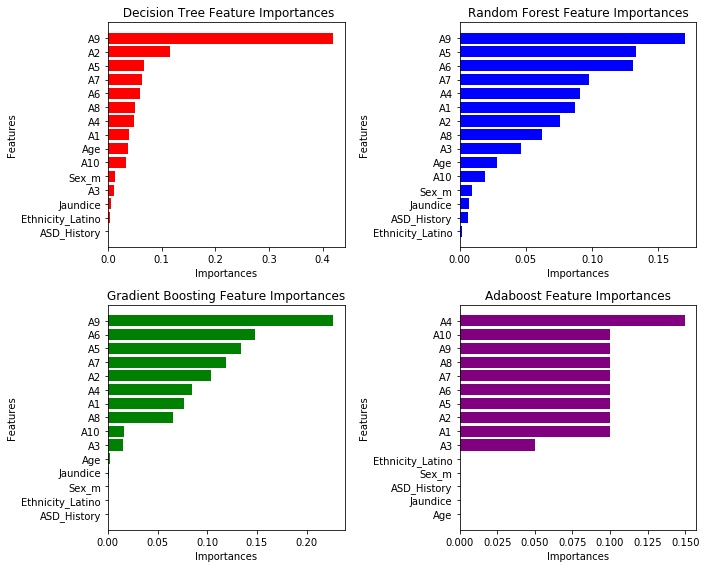

In [40]:
plot_feature_importance(model_list)

The feature importances show that:
- A9 is the strongest predictor for all models examined except for Adaboost with A4 being the strongest predictor
- For other models except Adaboost, there is variation in feature importance for the A predictors.
- For Adaboost, only the A predictors are important and they have almost equal importance except A3 and A4
In general, responses to questions A1-A10 mostly determine whether a child will develop autism or not

In [41]:
#save final model
with open('ASD_Toddler_model.pkl', 'wb') as final_model:
    pkl.dump(gs_adb.best_estimator_, final_model)

**Summary**

Autism dataset consisting of 1054 rows and 19 columns were explored and a model that predicts whether an child will be diagonised with autism disorder was built from features comprising of set of behavioural questions about the participants (A1-A10) and some personal information. Correlation plot of the features with the target revealed that A1-A10 features more strongly correlated with the features and could be better predictors. 
A model that predicts the majority class was chosen as the baseline and different models were tested including Naive Bayes, Decision tree, Random forest, Gradient boosting and Adaboost. The f1 score was chosen as a metric to measure the performance of the models and it was found that Adaboost has the the highest f1 score and was chosen as the best model. An improvement of 30% on the baseline model was observed. Plots of feature importances show that A9 in general has the strongest predictive power except in the case of Adaboost which has A4 as the best model.


<img src="A.png">